In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

#set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print('Libraries loaded successfully!')
print(f'Analysis date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Libraries loaded successfully!
Analysis date: 2025-07-05 22:49:06


In [7]:
#load data
#find most recent data files
data_dir = '../data/raw/'
print(f'Looking for data files in: {data_dir}')

#find spotify data file
spotify_files = [f for f in os.listdir(data_dir) if f.startswith('all_spotify_data_') and f.endswith('.csv')]
if spotify_files:
    latest_spotify_file = sorted(spotify_files)[-1]
    spotify_df = pd.read_csv(os.path.join(data_dir, latest_spotify_file))
    print(f'Loaded Spotify data from: {latest_spotify_file}')
    print(f'Spotify data shape: {spotify_df.shape}')
else:
    print('No Spotify data files found!')
    spotify_df = pd.DataFrame()
    

#find last.fm data file
lastfm_files = [f for f in os.listdir(data_dir) if f.startswith('all_lastfm_data_') and f.endswith('.json')]
if lastfm_files:
    latest_lastfm_file = sorted(lastfm_files)[-1]
    with open(os.path.join(data_dir, latest_lastfm_file), 'r') as f:
        lastfm_df = json.load(f)
    print(f'Loaded Last.fm data from: {latest_lastfm_file}')
    print(f'Last.fm cities: {len(lastfm_df)}')
else:
    print('No Last.fm data files found!')
    lastfm_data = {}

#find demographics data file
demo_files = [f for f in os.listdir(data_dir) if f.startswith('all_demographic_data_') and f.endswith('.json')]
if demo_files:
    latest_demo_file = sorted(demo_files)[-1]
    with open(os.path.join(data_dir, latest_demo_file), 'r') as f:
        demographic_data = json.load(f)
    print(f'Loaded demographic data from: {latest_demo_file}')
    print(f'Demographic data cities: {len(demographic_data)}')
else:
    print('No demographic data files found!')
    demographic_data = {}
    
print(f'\nData loading complete!')

Looking for data files in: ../data/raw/
Loaded Spotify data from: all_spotify_data_20250705_222627.csv
Spotify data shape: (1600, 17)
Loaded Last.fm data from: all_lastfm_data_20250705_222627.json
Last.fm cities: 8
Loaded demographic data from: all_demographic_data_20250705_222627.json
Demographic data cities: 8

Data loading complete!


In [10]:
#basic data overview
print(f'\nBASIC DATA OVERVIEW:')
print('='*50)

if not spotify_df.empty:
    print(f'Total tracks collected: {len(spotify_df):,}')
    print(f'Cities in dataset: {spotify_df["city"].nunique()}')
    print(f'Unique artists: {spotify_df["artist_name"].nunique()}')
    print(f'Unique albums: {spotify_df["album_name"].nunique()}')
    
    print(f'\nTracks per city:')
    city_counts = spotify_df['city'].value_counts()
    for city, count in city_counts.items():
        print(f'  {city}: {count:,} tracks')
        
    print(f'\nDate range:')
    spotify_df['release_data_clean'] = pd.to_datetime(spotify_df['release_date'], errors='coerce')
    min_date = spotify_df['release_data_clean'].min()
    max_date = spotify_df['release_data_clean'].max()
    print(f"   From: {min_date.strftime('%Y-%m-%d') if pd.notna(min_date) else 'Unknown'}")
    print(f"   To: {max_date.strftime('%Y-%m-%d') if pd.notna(max_date) else 'Unknown'}")
    
    print(f'Data completeness:')
    completion_rates = {}
    for col in spotify_df.columns:
        if col != 'preview_url':
            non_null_pct = (spotify_df[col].notna().sum() / len(spotify_df)) * 100
            completion_rates[col] = non_null_pct
            if non_null_pct < 95:
                print(f'  {col}: {non_null_pct:.1f}% complete')
            else:
                print(f'  {col}: {non_null_pct:.1f}% complete')


BASIC DATA OVERVIEW:
Total tracks collected: 1,600
Cities in dataset: 8
Unique artists: 651
Unique albums: 1152

Tracks per city:
  Nashville: 200 tracks
  Los Angeles: 200 tracks
  Chicago: 200 tracks
  Miami: 200 tracks
  New York: 200 tracks
  Seattle: 200 tracks
  Austin: 200 tracks
  Atlanta: 200 tracks

Date range:
   From: 1942-01-01
   To: 2025-07-04
Data completeness:
  track_id: 100.0% complete
  track_name: 100.0% complete
  artist_name: 100.0% complete
  album_name: 100.0% complete
  release_date: 100.0% complete
  popularity: 100.0% complete
  duration_ms: 100.0% complete
  explicit: 100.0% complete
  playlist_source: 100.0% complete
  playlist_id: 100.0% complete
  city: 100.0% complete
  artist_genres: 71.4% complete
  artist_popularity: 100.0% complete
  artist_followers: 100.0% complete
  track_popularity: 100.0% complete
  markets_available: 100.0% complete
  release_data_clean: 92.5% complete


In [11]:
#data quality assessment
print(f'\nDATA QUALITY ASSESSMENT:')
print('='*50)

if not spotify_df.empty:
    #check for duplicates
    duplicates = spotify_df.duplicated(subset=['track_id']).sum()
    print(f'Duplicate tracks: {duplicates}')
    
    #check for missing values
    print(f'\nMissing values by column:')
    missing_data = spotify_df.isnull().sum()
    for col, missing in missing_data.items():
        if missing > 0:
            pct_missing = (missing / len(spotify_df)) * 100
            print(f'  {col}: {missing} ({pct_missing:.1f}%)')
            
    #check data types
    print(f'\nData types:')
    for col in ['artist_popularity', 'track_popularity', 'artist_followers', 'duration_ms']:
        if col in spotify_df.columns:
            dtype = spotify_df[col].dtype
            print(f'  {col}: {dtype}')
    
    #check for outliers
    print(f'\n Potential Outliers:')
    numeric_cols = ['artist_popularity', 'track_popularity', 'artist_followers', 'duration_ms']
    for col in numeric_cols:
        if col in spotify_df.columns:
            q1 = spotify_df[col].quantile(0.25)
            q3 = spotify_df[col].quantile(0.75)
            iqr = q3 - q1
            outliers = spotify_df[(spotify_df[col] < q1 - 1.5 * iqr) | (spotify_df[col] > q3 + 1.5 * iqr)][col]
            print(f'  {col} outliers: {len(outliers)} outliers')


DATA QUALITY ASSESSMENT:
Duplicate tracks: 38

Missing values by column:
  artist_genres: 457 (28.6%)
  preview_url: 1600 (100.0%)
  release_data_clean: 120 (7.5%)

Data types:
  artist_popularity: int64
  track_popularity: int64
  artist_followers: int64
  duration_ms: int64

 Potential Outliers:
  artist_popularity outliers: 61 outliers
  track_popularity outliers: 0 outliers
  artist_followers outliers: 179 outliers
  duration_ms outliers: 97 outliers


In [12]:
#spotify data sample inspection
print(f'\nSPOTIFY DATA SAMPLE INSPECTION:')
print('='*50)

if not spotify_df.empty:
    print('First 5 rows of Spotify data:')
    display_cols = ['track_name','artist_name','city','artist_genres','artist_popularity','track_popularity']
    available_cols = [col for col in display_cols if col in spotify_df.columns]
    print(spotify_df[available_cols].head())
    
    print(f'\nColumn names ({len(spotify_df.columns)} total):')
    for i, col in enumerate(spotify_df.columns, 1):
        print(f'  {i:2d}. {col}')


SPOTIFY DATA SAMPLE INSPECTION:
First 5 rows of Spotify data:
                 track_name      artist_name       city  \
0         Tennessee Whiskey  Chris Stapleton  Nashville   
1  Barefoot Blue Jean Night        Jake Owen  Nashville   
2             Play It Again       Luke Bryan  Nashville   
3          Drink In My Hand      Eric Church  Nashville   
4               Wagon Wheel    Darius Rucker  Nashville   

               artist_genres  artist_popularity  track_popularity  
0    country, outlaw country                 85                88  
1  country, acoustic country                 67                79  
2  country, acoustic country                 80                81  
3  country, acoustic country                 77                80  
4                    country                 71                84  

Column names (18 total):
   1. track_id
   2. track_name
   3. artist_name
   4. album_name
   5. release_date
   6. popularity
   7. duration_ms
   8. explicit
   9. playli

In [14]:
#genre analysis by city
print(f'\nGENRE ANALYSIS BY CITY:')
print('='*50)

if not spotify_df.empty and 'artist_genres' in spotify_df.columns:
    genre_analysis = {}
    
    for city in spotify_df['city'].unique():
        city_data = spotify_df[spotify_df['city'] == city]
        
        #extract individual genres
        all_genres = []
        for genres_str in city_data['artist_genres'].dropna():
            if genres_str and genres_str.strip():
                genres = [g.strip() for g in genres_str.split(',') if g.strip()]
                all_genres.extend(genres)
                
        if all_genres:
            #count genres
            genre_counts = pd.Series(all_genres).value_counts()
            
            #store analysis
            genre_analysis[city] = {
                'total_tracks': len(city_data),
                'tracks_with_genres': city_data['artist_genres'].notna().sum(),
                'unique_genres': genre_counts.index.tolist(),
                'top_genres': genre_counts.head(10)
            }
            
            
            print(f'\n {city}:')
            print(f'  Tracks: {len(city_data)}')
            print(f'  Tracks with genres: {city_data["artist_genres"].notna().sum()}')
            print(f'  Unique genres: {len(genre_counts)}')
            print(f'  Top 5 genres:')
            for genre, count in genre_counts.head(5).items():
                pct = (count / len(city_data)) * 100
                print(f'    {genre}: {count} ({pct:.1f}%)')
        else:
            print(f'\n {city}: No genres found')


GENRE ANALYSIS BY CITY:

 Nashville:
  Tracks: 200
  Tracks with genres: 191
  Unique genres: 16
  Top 5 genres:
    country: 186 (93.0%)
    acoustic country: 59 (29.5%)
    red dirt: 24 (12.0%)
    texas country: 18 (9.0%)
    outlaw country: 12 (6.0%)

 Los Angeles:
  Tracks: 200
  Tracks with genres: 163
  Unique genres: 109
  Top 5 genres:
    west coast hip hop: 81 (40.5%)
    gangster rap: 67 (33.5%)
    g-funk: 60 (30.0%)
    old school hip hop: 59 (29.5%)
    hip hop: 45 (22.5%)

 Chicago:
  Tracks: 200
  Tracks with genres: 180
  Unique genres: 48
  Top 5 genres:
    chicago drill: 99 (49.5%)
    drill: 89 (44.5%)
    chicago house: 53 (26.5%)
    footwork: 13 (6.5%)
    acid house: 13 (6.5%)

 Miami:
  Tracks: 200
  Tracks with genres: 112
  Unique genres: 48
  Top 5 genres:
    edm: 27 (13.5%)
    hypertechno: 25 (12.5%)
    big room: 14 (7.0%)
    latin: 9 (4.5%)
    house: 8 (4.0%)

 New York:
  Tracks: 200
  Tracks with genres: 65
  Unique genres: 26
  Top 5 genres:
   

In [16]:
#popularity and followers analysis
print(f'\nPOPULARITY AND FOLLOWERS ANALYSIS:')
print('='*50)

if not spotify_df.empty:
    numeric_cols = ['artist_popularity', 'track_popularity', 'artist_followers']
    available_numeric = [col for col in numeric_cols if col in spotify_df.columns]
    
    if available_numeric:
        print('Summary statistics by city:')
        
        for city in spotify_df['city'].unique():
            city_data = spotify_df[spotify_df['city'] == city]
            print(f'\n {city}:')
            
            for col in available_numeric:
                if col in city_data.columns:
                    mean = city_data[col].mean()
                    median = city_data[col].median()
                    std = city_data[col].std()
                    
                    if col == 'artist_followers':
                        print(f'  {col}: μ={mean:,.0f}, median={median:,.0f}, σ={std:,.0f}')
                    else:
                        print(f'  {col}: μ={mean:,.1f}, median={median:,.1f}, σ={std:,.1f}')



POPULARITY AND FOLLOWERS ANALYSIS:
Summary statistics by city:

 Nashville:
  artist_popularity: μ=74.7, median=77.0, σ=9.3
  track_popularity: μ=56.1, median=65.0, σ=27.8
  artist_followers: μ=4,477,194, median=2,515,967, σ=9,189,007

 Los Angeles:
  artist_popularity: μ=64.0, median=67.0, σ=17.6
  track_popularity: μ=37.7, median=44.0, σ=29.2
  artist_followers: μ=5,691,156, median=1,997,778, σ=8,900,275

 Chicago:
  artist_popularity: μ=56.5, median=60.5, σ=23.1
  track_popularity: μ=26.8, median=26.0, σ=26.3
  artist_followers: μ=3,016,348, median=352,860, σ=4,131,405

 Miami:
  artist_popularity: μ=72.8, median=78.0, σ=17.8
  track_popularity: μ=67.2, median=76.0, σ=21.6
  artist_followers: μ=14,458,266, median=4,436,734, σ=22,699,857

 New York:
  artist_popularity: μ=78.5, median=84.0, σ=18.3
  track_popularity: μ=73.2, median=81.0, σ=20.2
  artist_followers: μ=33,460,531, median=16,928,611, σ=38,573,742

 Seattle:
  artist_popularity: μ=67.5, median=67.0, σ=10.6
  track_popula

In [18]:
#release date analysis
print(f'\nRELEASE DATE ANALYSIS:')
print('='*50)

if not spotify_df.empty and 'release_data_clean' in spotify_df.columns:
    #extract years
    spotify_df['release_year'] = pd.to_datetime(spotify_df['release_data_clean'], errors='coerce').dt.year
    
    print('Release year distribution by city:')
    
    for city in spotify_df['city'].unique():
        city_data = spotify_df[spotify_df['city'] == city]
        valid_years = city_data['release_year'].dropna()
        
        if len(valid_years) > 0:
            min_year = valid_years.min()
            max_year = valid_years.max()
            median_year = valid_years.median()
            
            #count by decade
            decades = {}
            for year in valid_years:
                decade = (int(year) // 10) * 10
                decades[decade] = decades.get(decade, 0) + 1
                
            print(f'\n {city}:')
            print(f'  Year Range: {min_year:.0f} - {max_year:.0f}')
            print(f'  Median Year: {median_year:.0f}')
            print(f' Top decades:')
            for decade, count in sorted(decades.items(), key=lambda x: x[1], reverse=True)[:3]:
                pct = (count / len(valid_years)) * 100
                print(f'    {decade}s: {count} tracks ({pct:.1f}%)')


RELEASE DATE ANALYSIS:
Release year distribution by city:

 Nashville:
  Year Range: 1997 - 2025
  Median Year: 2018
 Top decades:
    2010s: 124 tracks (62.0%)
    2020s: 53 tracks (26.5%)
    2000s: 22 tracks (11.0%)

 Los Angeles:
  Year Range: 1957 - 2024
  Median Year: 2000
 Top decades:
    1990s: 46 tracks (27.4%)
    2010s: 41 tracks (24.4%)
    2000s: 35 tracks (20.8%)

 Chicago:
  Year Range: 1983 - 2021
  Median Year: 2018
 Top decades:
    2010s: 89 tracks (47.8%)
    2020s: 60 tracks (32.3%)
    1990s: 18 tracks (9.7%)

 Miami:
  Year Range: 1997 - 2025
  Median Year: 2018
 Top decades:
    2020s: 92 tracks (46.9%)
    2010s: 65 tracks (33.2%)
    2000s: 37 tracks (18.9%)

 New York:
  Year Range: 1997 - 2025
  Median Year: 2012
 Top decades:
    2010s: 114 tracks (60.3%)
    2000s: 38 tracks (20.1%)
    2020s: 35 tracks (18.5%)

 Seattle:
  Year Range: 1942 - 2023
  Median Year: 1996
 Top decades:
    1990s: 67 tracks (40.4%)
    2010s: 31 tracks (18.7%)
    2000s: 25 tr

In [20]:
#last.fm data analysis
print(f'\nLAST.FM DATA ANALYSIS:')
print('='*50)

if lastfm_data:
    print(f'Last.fm data summary:')
    print(f'Cities with Last.fm data: {len(lastfm_data)}')
    
    total_lastfm_tracks = 0
    for city, data in lastfm_data.items():
        track_count = len(data.get('top_tracks', []))
        total_lastfm_tracks += track_count
        print(f'  {city}: {track_count} tracks')
    
    print(f'Total Last.fm tracks: {total_lastfm_tracks}')
    
    #sample last.fm data
    if lastfm_data:
        sample_city = list(lastfm_data.keys())[0]
        sample_tracks = lastfm_data[sample_city].get('top_tracks', [])[:3]
        
        print(f'\nSample Last.fm trCKS from {sample_city}:')
        for i, track in enumerate(sample_tracks, 1):
            name = track.get('name', 'Unknown')
            artist = track.get('artist', 'Unknown')
            playcount = track.get('playcount', 0)
            print(f'  {i}. "{name}" by {artist} ({playcount:,} plays)')
            
    else:
        print('No Last.fm data available.')
        


LAST.FM DATA ANALYSIS:
Last.fm data summary:
Cities with Last.fm data: 8
  Nashville: 50 tracks
  Los Angeles: 50 tracks
  Chicago: 50 tracks
  Miami: 50 tracks
  New York: 50 tracks
  Seattle: 50 tracks
  Austin: 50 tracks
  Atlanta: 50 tracks
Total Last.fm tracks: 400

Sample Last.fm trCKS from Nashville:
  1. "Mr. Brightside" by The Killers (0 plays)
  2. "Float On" by Modest Mouse (0 plays)
  3. "The Less I Know the Better" by Tame Impala (0 plays)


In [29]:
#demographics data analysis
print(f'\nDEMOGRAPHICS DATA ANALYSIS:')
print('='*50)

if demographic_data:
    print(f'Demographic data summary:')
    print(f'Cities with demographic data: {len(demographic_data)}')
    
    #create demographic summary
    demo_df_data = []
    for city, data in demographic_data.items():
        demo_df_data.append({
            'city': city,
            'population': data.get('population'),
            'median_age': data.get('median_age'),
            'median_income': data.get('median_household_income'),
            'bachelor_plus_pct': data.get('education_bachelor_plus_percent'),
            'urban_class': data.get('urban_classification')
        })
    
    demo_df = pd.DataFrame(demo_df_data)
    
    print(f'\nDemographic overview:')
    for _, row in demo_df.iterrows():
        city = row['city']
        pop = f"{row['population']:,}" if pd.notna(row['population']) else "Unknown"
        age = f"{row['median_age']:.1f}" if pd.notna(row['median_age']) else "Unknown"
        income = f"${row['median_income']:,}" if pd.notna(row['median_income']) else "Unknown"
        education = f"{row['bachelor_plus_pct']:.1f}%" if pd.notna(row['bachelor_plus_pct']) else "Unknown"
        urban = row['urban_class'] if pd.notna(row['urban_class']) else "Unknown"
        
        print(f'\n{city}:')
        print(f' Population: {pop}')
        print(f' Median Age: {age}')
        print(f' Median Income: {income}')
        print(f' Bachelor+ %: {education}')
        print(f' Urban Classification: {urban}')
else:
    print('No demographic data available.')


DEMOGRAPHICS DATA ANALYSIS:
Demographic data summary:
Cities with demographic data: 8

Demographic overview:

Nashville:
 Population: 684,103
 Median Age: 34.6
 Median Income: $71,328
 Bachelor+ %: 28.1%
 Urban Classification: Large City

Los Angeles:
 Population: 3,881,041
 Median Age: 36.5
 Median Income: $76,244
 Bachelor+ %: 23.9%
 Urban Classification: Major City

Chicago:
 Population: 2,721,914
 Median Age: 35.3
 Median Income: $71,673
 Bachelor+ %: 24.4%
 Urban Classification: Major City

Miami:
 Population: 443,665
 Median Age: 39.7
 Median Income: $54,858
 Bachelor+ %: 20.6%
 Urban Classification: Large City

New York:
 Population: 8,622,467
 Median Age: 37.5
 Median Income: $76,607
 Bachelor+ %: 23.2%
 Urban Classification: Major City

Seattle:
 Population: 734,603
 Median Age: 35.4
 Median Income: $116,068
 Bachelor+ %: 37.3%
 Urban Classification: Large City

Austin:
 Population: 958,202
 Median Age: 34.2
 Median Income: $86,556
 Bachelor+ %: 34.9%
 Urban Classification: L


CREATING BASIC VISUALIZATIONS:


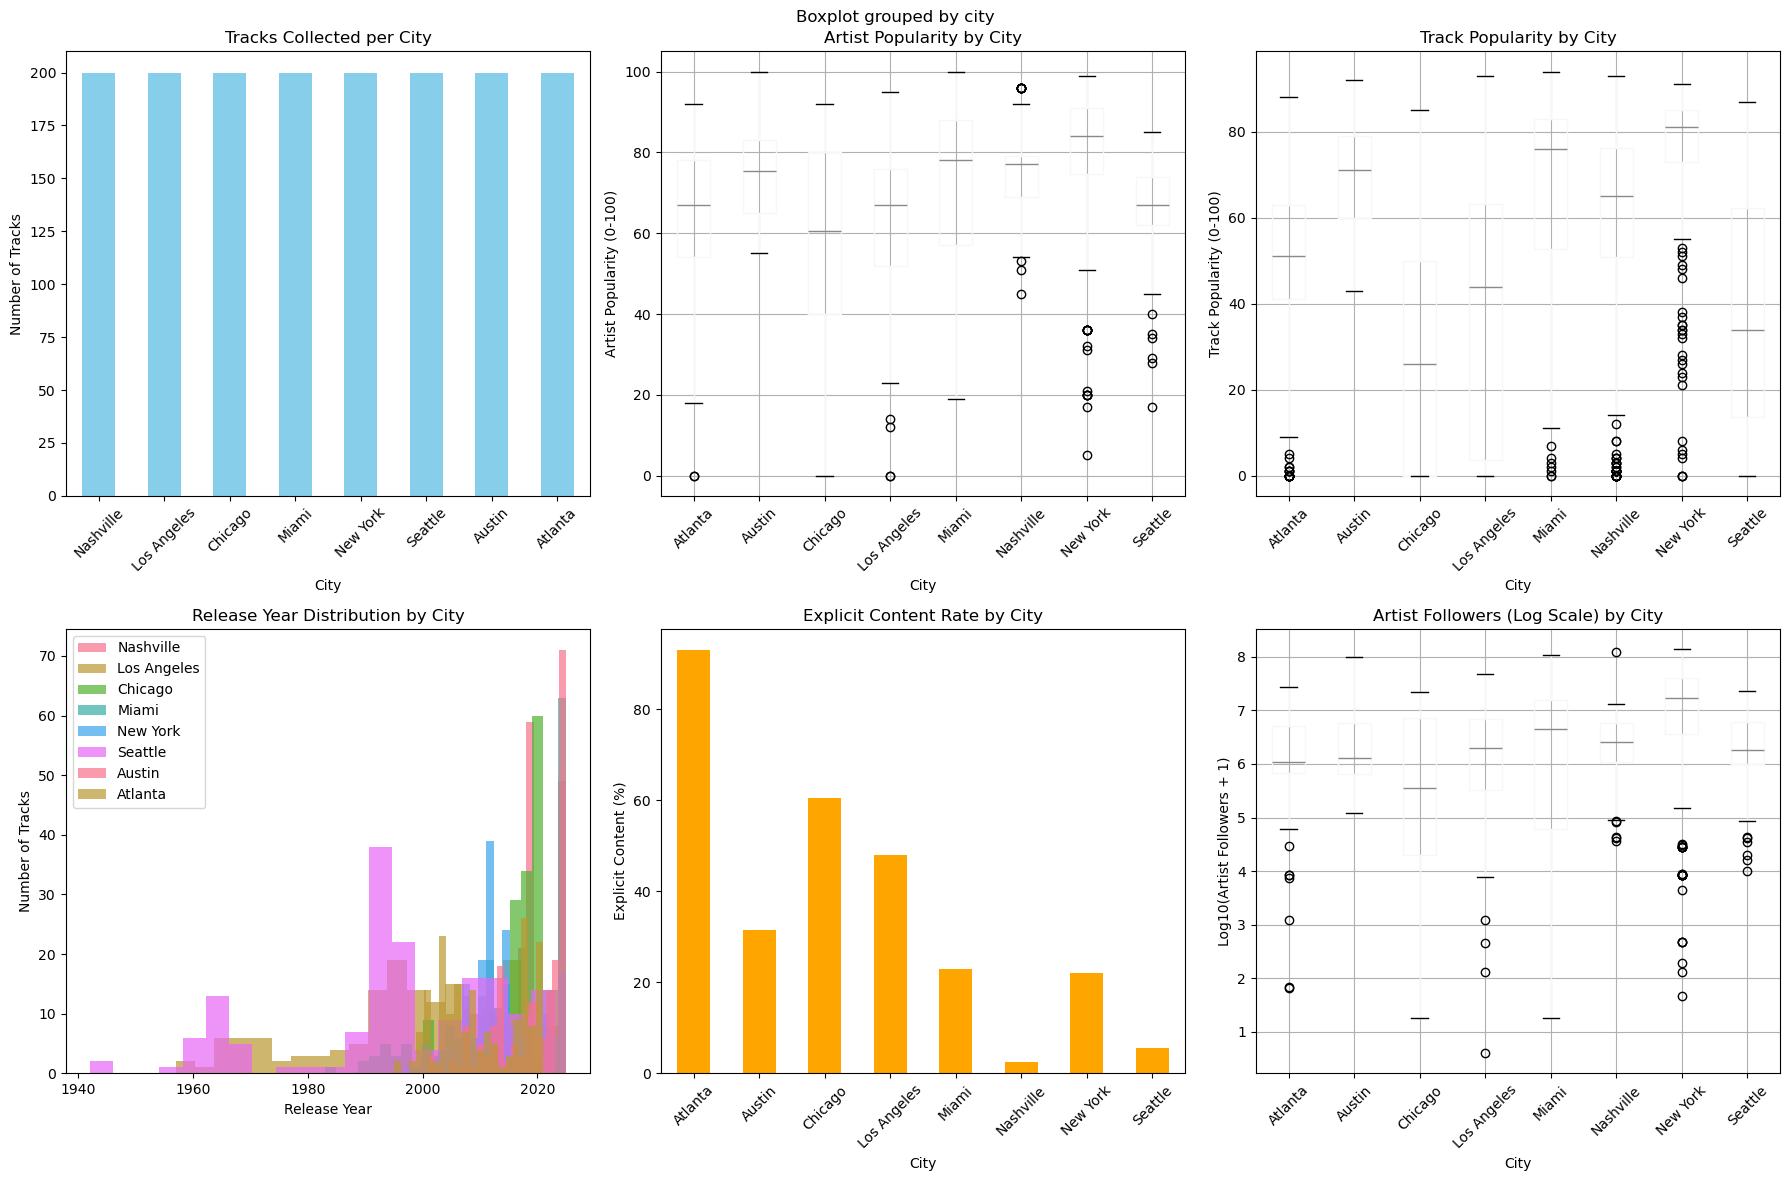

Basic visualizations created!


In [26]:
#create basic vizs
print(f'\nCREATING BASIC VISUALIZATIONS:')
print('='*50)

if not spotify_df.empty:
    #set up plot area
    fig, axes = plt.subplots(2,3, figsize=(18, 12))
    fig.suptitle('Regional Music DNA - Data Overview', fontsize=16, fontweight='bold')
    
    #tracks per city
    city_counts = spotify_df['city'].value_counts()
    city_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Tracks Collected per City')
    axes[0,0].set_xlabel('City')
    axes[0,0].set_ylabel('Number of Tracks')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    #artist popularity by city
    if 'artist_popularity' in spotify_df.columns:
        spotify_df.boxplot(column='artist_popularity', by='city', ax=axes[0,1])
        axes[0,1].set_title('Artist Popularity by City')
        axes[0,1].set_xlabel('City')
        axes[0,1].set_ylabel('Artist Popularity (0-100)')
        axes[0,1].tick_params(axis='x', rotation=45)
    else:
        axes[0,1].text(0.5, 0.5, 'Artist Popularity\nData Not Available', 
                       ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Artist Popularity by City')
    
    #track popularity by city
    if 'track_popularity' in spotify_df.columns:
        spotify_df.boxplot(column='track_popularity', by='city', ax=axes[0,2])
        axes[0,2].set_title('Track Popularity by City')
        axes[0,2].set_xlabel('City')
        axes[0,2].set_ylabel('Track Popularity (0-100)')
        axes[0,2].tick_params(axis='x', rotation=45)
    else:
        axes[0,2].text(0.5, 0.5, 'Track Popularity\nData Not Available', 
                       ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Track Popularity by City')
    
    
    #release year distribution
    if 'release_year' in spotify_df.columns:
        for city in spotify_df['city'].unique():
            city_data = spotify_df[spotify_df['city'] == city]
            valid_years = city_data['release_year'].dropna()
            if len(valid_years) > 0:
                axes[1,0].hist(valid_years, alpha=0.7, label=city, bins=20)
        axes[1,0].set_title('Release Year Distribution by City')
        axes[1,0].set_xlabel('Release Year')
        axes[1,0].set_ylabel('Number of Tracks')
        axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'Release Year\nData Not Available', 
                       ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Release Year Distribution by City')
        
    #explicit content rate by city
    if 'explicit' in spotify_df.columns:
        explicit_rates = spotify_df.groupby('city')['explicit'].mean() * 100
        explicit_rates.plot(kind='bar', ax=axes[1,1], color='orange')
        axes[1,1].set_title('Explicit Content Rate by City')
        axes[1,1].set_xlabel('City')
        axes[1,1].set_ylabel('Explicit Content (%)')
        axes[1,1].tick_params(axis='x', rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, 'Explicit Content\nData Not Available', 
                       ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Explicit Content Rate by City')
        
    #artist followers distribution (log scale)
    if 'artist_followers' in spotify_df.columns:
        spotify_df['log_followers'] = np.log10(spotify_df['artist_followers'] + 1)
        spotify_df.boxplot(column='log_followers', by='city', ax=axes[1,2])
        axes[1,2].set_title('Artist Followers (Log Scale) by City')
        axes[1,2].set_xlabel('City')
        axes[1,2].set_ylabel('Log10(Artist Followers + 1)')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].text(0.5, 0.5, 'Artist Followers\nData Not Available', 
                       ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Artist Followers (Log Scale) by City')
        
    plt.tight_layout()
    plt.show()
    
    print('Basic visualizations created!')
else:
    print('No Spotify data available for visualizations.')

In [28]:
#data validation summary
print(f'\nDATA VALIDATION SUMMARY:')
print('='*50)

validation_results = {
    'spotify_data_loaded': not spotify_df.empty,
    'lastfm_data_loaded': bool(lastfm_data),
    'demographic_data_loaded': bool(demographic_data),
    'total_tracks': len(spotify_df) if not spotify_df.empty else 0,
    'total_cities': spotify_df['city'].nunique() if not spotify_df.empty else 0,
    'data_quality_issues': []
}

#check for data quality issues
if not spotify_df.empty:
    #check for missing critical data
    if spotify_df['track_name'].isnull().sum() > 0:
        validation_results['data_quality_issues'].append('Missing track names')
    if spotify_df['artist_name'].isnull().sum() > 0:
        validation_results['data_quality_issues'].append('Missing artist names')
    if spotify_df['city'].isnull().sum() > 0:
        validation_results['data_quality_issues'].append('Missing city information')
        
    #check for duplicates
    if spotify_df.duplicated(subset=['track_id']).sum() > 0:
        validation_results['data_quality_issues'].append('Duplicate track IDs found')
        
    #check city distribution
    city_counts = spotify_df['city'].value_counts()
    if city_counts.std() > city_counts.mean()*0.5:
        validation_results['data_quality_issues'].append('Uneven track distribution across cities')
        

print('Validation Results:')
print(f"  Spotify data loaded: {validation_results['spotify_data_loaded']}")
print(f"  Last.fm data loaded: {validation_results['lastfm_data_loaded']}")
print(f"  Demographic data loaded: {validation_results['demographic_data_loaded']}")
print(f"  Total tracks: {validation_results['total_tracks']:,}")
print(f"  Total cities: {validation_results['total_cities']}")
      
if validation_results['data_quality_issues']:
    print(f"  Data quality issues found:")
    for issue in validation_results['data_quality_issues']:
        print(f"    - {issue}")
else:
    print(f"  No significant data quality issues found.")
    
print(f'\nData validation complete!')
print('Dataset is ready for analysis!')


DATA VALIDATION SUMMARY:
Validation Results:
  Spotify data loaded: True
  Last.fm data loaded: True
  Demographic data loaded: True
  Total tracks: 1,600
  Total cities: 8
  Data quality issues found:
    - Duplicate track IDs found

Data validation complete!
Dataset is ready for analysis!
